# 0.**Librerias**

In [ ]:
!pip install -U torch --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate datasets bitsandbytes triton peft trl \
    bert-score textstat numpy pandas
# ===============================
# ✅ LIMPIEZA DE SALIDA Y VERIFICACIÓN DE VERSIONES
# ===============================
import IPython
IPython.display.clear_output(wait=True)


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached triton-3.5.1-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (1.7 kB)


In [ ]:
import torch, transformers, peft, trl, accelerate, bitsandbytes, datasets

print("✅ Librerías cargadas correctamente:\n")
print(f"PyTorch:        {torch.__version__}")
print(f"Transformers:   {transformers.__version__}")
print(f"PEFT:           {peft.__version__}")
print(f"TRL:            {trl.__version__}")
print(f"Accelerate:     {accelerate.__version__}")
print(f"Datasets:       {datasets.__version__}")
print(f"BitsAndBytes:   {bitsandbytes.__version__}")

print("\n✨ Entorno listo para QLoRA 4-bit + SFTTrainer + TRL 0.24.0 ✨")

✅ Librerías cargadas correctamente:

PyTorch:        2.9.0+cu126
Transformers:   4.57.1
PEFT:           0.18.0
TRL:            0.25.1
Accelerate:     1.12.0
Datasets:       4.4.1
BitsAndBytes:   0.48.2

✨ Entorno listo para QLoRA 4-bit + SFTTrainer + TRL 0.24.0 ✨


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Crear carpeta y entrar
!mkdir cochrane_data
%cd cochrane_data

# 2. Inicializar git vacío
!git init

# 3. Agregar remote
!git remote add -f origin https://github.com/feliperussi/bridging-the-gap-in-health-literacy.git

# 4. Activar modo sparse checkout
!git config core.sparseCheckout true

# 5. Indicar SOLO las carpetas que queremos
!echo "data_collection_and_processing/Data Sources/Cochrane/train/pls" >> .git/info/sparse-checkout
!echo "data_collection_and_processing/Data Sources/Cochrane/train/non_pls" >> .git/info/sparse-checkout

# 6. Descargar solo esa parte del repo
!git pull origin main


/content/cochrane_data
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/cochrane_data/.git/
Updating origin
remote: Enumerating objects: 72074, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 72074 (delta 0), reused 2 (delta 0), pack-reused 72071 (from 2)
Receiving objects: 100% (72074/72074), 315.90 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (2991/2991), done.
From https://github.com/feliperussi/bridging-the-gap-in-health-literacy
 * [new branch]

Gestionar Hugging Face

In [ ]:
import os
os.environ["HF_TOKEN"] = "hf_"

In [ ]:
from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments
from peft import LoraConfig, get_peft_model
import glob, pandas as pd
import transformers, trl, peft, accelerate, datasets
import bitsandbytes as bnb
import re

# 1.Construir el dataset non_pls → pls desde las carpetas de GitHub

In [ ]:

# Número máximo de pares
pares = 2000

# === 1️⃣ Listar archivos ===
pls_files = sorted(glob.glob("data_collection_and_processing/Data Sources/Cochrane/train/pls/*.txt"))
non_pls_files = sorted(glob.glob("data_collection_and_processing/Data Sources/Cochrane/train/non_pls/*.txt"))

# === 2️⃣ Filtrar archivos que contengan 'accumulated' en AMBOS ---
pls_files = [f for f in pls_files if "accumulated" not in os.path.basename(f).lower()]
non_pls_files = [f for f in non_pls_files if "accumulated" not in os.path.basename(f).lower()]

print(f"📚 Total PLS (sin accumulated): {len(pls_files)}")
print(f"📂 Total non-PLS (sin accumulated): {len(non_pls_files)}")

# === 3️⃣ Función para extraer el ID base ===
def extract_id(filename):
    base = os.path.basename(filename)
    match = re.match(r"(.+?)\.pub\d+", base)
    return match.group(1) if match else base.split(".txt")[0]

# === 4️⃣ Diccionarios {id_base: ruta} ===
pls_dict = {extract_id(p): p for p in pls_files}
non_pls_dict = {extract_id(n): n for n in non_pls_files}

# === 5️⃣ Emparejar ===
data = []
for base_id, non_path in non_pls_dict.items():
    if base_id in pls_dict:
        pls_path = pls_dict[base_id]
        with open(pls_path, "r", encoding="utf-8") as f1, open(non_path, "r", encoding="utf-8") as f2:
            data.append({
                "id": base_id,
                "file_pls": os.path.basename(pls_path),
                "file_non_pls": os.path.basename(non_path),
                "pls": f1.read().strip(),
                "non_pls": f2.read().strip()
            })
    if len(data) >= pares:
        break

# === 6️⃣ DataFrame ===
df = pd.DataFrame(data)

# === 7️⃣ Guardar ===
output_path = "cochrane_pairs_clean.csv"
df.to_csv(output_path, index=False, encoding="utf-8")

print(f"\n✅ Emparejados {len(df)} pares por nombre base (sin 'accumulated' en ninguno)")
print(f"💾 Guardado en: {output_path}")
df.head(3)



📚 Total PLS (sin accumulated): 4797
📂 Total non-PLS (sin accumulated): 7251

✅ Emparejados 2000 pares por nombre base (sin 'accumulated' en ninguno)
💾 Guardado en: cochrane_pairs_clean.csv


,id,file_pls,file_non_pls,pls,non_pls
0,10.1002-14651858.CD000006,10.1002-14651858.CD000006.pub2-pls.txt,10.1002-14651858.CD000006.pub2-abstract.txt,Absorbable stitches for repair of episiotomy a...,Background\nApproximately 70% of women will ex...
1,10.1002-14651858.CD000009,10.1002-14651858.CD000009.pub4-pls.txt,10.1002-14651858.CD000009.pub4-abstract.txt_se...,Do acupuncture and related therapies help smok...,We included 38 studies. Based on three studies...
2,10.1002-14651858.CD000012,10.1002-14651858.CD000012.pub4-pls.txt,10.1002-14651858.CD000012.pub4-abstract.txt_se...,Alternative versus conventional institutional ...,"Ten trials involving 11,795 women met the incl..."


In [ ]:
#df.to_csv("/content/drive/MyDrive/cochrane_2000_train.csv", index=False, encoding="utf-8")

# 2.Test train split y generacion del prompt

In [ ]:
df = df.rename(columns={"non_pls": "source", "pls": "target"})

INSTR_PROMPT = """Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the description of the design,
description of study and patient population (age, health condition, gender), and the expected
amount of time a person will be in the study.
4. Results: Answer ‘What were the main results of the study’, include the benefits for the patients,
how the study was relevant for the area of study, and the conclusions from the investigator.
c. Consistency and Replicability: The generated PLS should be consistent regardless of the order of
sentences or the specific phrasing used in the input protocol text.
d. Compliance with Plain Language Guidelines: The generated PLS must follow all these plain
language guidelines:
• Have readability grade level of 6 or below.
• Do not have jargon. All technical or medical words or terms should be defined or broken down
into simple and logical explanations.
• Active voice, not passive.
• Mostly one or two syllable words.
• Sentences of 15 words or less.
• Short paragraphs of 3-5 sentences.
• Simple numbers (e.g., ratios, no percentages).
e. Do not invent Content: The AI model should not invent information. If the AI model includes data
other than the one given in the input abstract, the AI model should guarantee such data is verified and
real.
f. Aim for an approximate PLS length of 500-900 words.

Input abstract:

{source}

Output PLS:
"""

def format_example(row):
    prompt = INSTR_PROMPT.format(source=row["source"])
    return {"prompt": prompt, "response": row["target"]}

# Aplicar la función a cada fila del DataFrame
dataset = df.apply(format_example, axis=1).to_list()

# Crear Dataset de Hugging Face y dividir en train/test
from datasets import Dataset

hf_ds = Dataset.from_list(dataset).train_test_split(test_size=0.1, seed=42)

print(hf_ds)


DatasetDict({
    train: Dataset({
        features: ['prompt', 'response'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['prompt', 'response'],
        num_rows: 200
    })
})


## Mostrar uno al azar

In [ ]:
import random

idx = random.randint(0, len(hf_ds["train"]) - 1)
print(f"🔹 Ejemplo #{idx}")
print(hf_ds["train"][idx]["prompt"])

🔹 Ejemplo #1793
Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the descr

# 3.Training del Modelo (Modelo Base + QLoRA)

In [ ]:
MODELO="meta-llama/Llama-3.2-3B-Instruct"
num_train_epochs=8
COSINE_WEIGHT=0  #0.05
KL_WEIGHT=0.1    #0.05
base_model_name="meta-llama/Llama-3.2-3B-Instruct" #teacher

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorForSeq2Seq, BitsAndBytesConfig, AutoModel,TrainingArguments
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import os
import sys
import torch
from torch import nn
from transformers import Trainer
import textstat
import pyphen
import re


print("\n" + "="*80)
print("🚀 SETUP - OPCIÓN C FIXED")
print("="*80)

# 1. Cargar modelo base
model_id = MODELO
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True
)

print(f"\n📥 Cargando {model_id}...")
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token


#=============================================================================
 #Cargar embedding model:
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to("cpu")


# ============================================================================
# CUSTOM LOSS CON COSENO
# ============================================================================

# ============================================================================
# NUEVA VERSIÓN DIFERENCIABLE DEL COSINE LOSS (usa hidden states del modelo)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F

"""
============================================================================
OPCIÓN C - FIXED: Proyector registrado en el modelo
============================================================================

PROBLEMA IDENTIFICADO:
- El proyector tenía gradientes pero NO estaba en el optimizer
- Grupo 1 del optimizer: 0 params

SOLUCIÓN:
- Crear proyector ANTES del trainer
- Registrarlo como model.cosine_proj
- Pasarlo al loss
- El Trainer lo optimizará automáticamente

============================================================================
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    AutoModel,
    Trainer,
    TrainingArguments
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import gc

# ============================================================================
# PASO 1: Loss Function (recibe proyector externo)
# ============================================================================

class CosineAlignedLoss(nn.Module):
    """
    Loss combinada: CrossEntropy + Cosine + KL (regularización lingüística)
    """
    def __init__(
      self,
      embedding_model=None,
      embedding_tokenizer=None,
      cosine_weight=0,
      kl_weight=0,
      readability_weight=0,
      complexity_weight=0,
      proj=None,
      ref_model=None
  ):
      super().__init__()

      self.embedding_model = embedding_model
      self.embedding_tokenizer = embedding_tokenizer
      self.proj = proj
      self.ref_model = ref_model

      # Pesos de cada pérdida
      self.cosine_weight = cosine_weight
      self.kl_weight = kl_weight
      self.readability_weight = readability_weight   # ✔ CORREGIDO
      self.complexity_weight = complexity_weight     # ✔ CORREGIDO

      # Cross entropy correcta (sin smoothing para PPO/DPO)
      self.ce_loss = nn.CrossEntropyLoss(
          ignore_index=-100,
          #reduction="mean"
          label_smoothing=0.1
      )

      # Congelar ref_model si existe
      if self.ref_model is not None:
          for p in self.ref_model.parameters():
              p.requires_grad = False

      # Otros atributos
      self._debug_count = 0
      self.pyphen_dic = pyphen.Pyphen(lang='en')
      self.step_counter = 0
      self.compute_text_metrics_every = 5
      self.cached_readability = 0.0
      self.cached_complexity = 0.0

    # =============================================================
    # PASO 2: Funciones auxiliares
    # =============================================================

    def forward(self, outputs, labels, texts, inputs=None, tokenizer=None):

      # =============================================================
      # 1) CROSS-ENTROPY (shift + ignore_index + stable)
      # =============================================================
      shift_logits = outputs.logits[..., :-1, :].contiguous()
      shift_labels = labels[..., 1:].contiguous()

      ce_loss = self.ce_loss(
          shift_logits.view(-1, shift_logits.size(-1)),
          shift_labels.view(-1)
      )

      total_loss = ce_loss

      # Inicializar pérdidas adicionales
      device = outputs.logits.device
      cosine_loss = torch.zeros(1, device=device)
      kl_loss = torch.zeros(1, device=device)
      readability_loss = torch.zeros(1, device=device)
      complexity_loss = torch.zeros(1, device=device)

      # =============================================================
      # 2) COSINE LOSS
      # =============================================================
      if (
          self.cosine_weight > 0
          and self.embedding_model is not None
          and self.proj is not None
          and outputs.hidden_states is not None
          and texts
      ):
          hidden = outputs.hidden_states[-1]
          mask = (labels != -100).float().unsqueeze(-1)
          student_vec = (hidden * mask).sum(1) / (mask.sum(1) + 1e-8)
          student_vec = F.normalize(self.proj(student_vec), dim=-1)

          # Embedding reference
          with torch.no_grad():
              emb_inputs = self.embedding_tokenizer(
                  texts, padding=True, truncation=True, max_length=512,
                  return_tensors="pt"
              ).to(self.embedding_model.device)

              ref_emb = self.embedding_model(**emb_inputs).last_hidden_state.mean(1)
              ref_emb = F.normalize(ref_emb, dim=-1).to(device)

          cosine_loss = (1 - F.cosine_similarity(student_vec, ref_emb, dim=-1)).mean()

          total_loss = total_loss + self.cosine_weight * cosine_loss

      # =============================================================
      # 3) KL DIVERGENCE (teacher-student)
      # =============================================================

      if self.kl_weight > 0 and self.ref_model is not None and inputs is not None:

          # ✔ Obtener device correcto del teacher
          ref_device = next(self.ref_model.parameters()).device

          with torch.no_grad():
              # Mover inputs al device del teacher
              ref_inputs = {
                  k: v.to(ref_device)
                  for k, v in inputs.items()
                  if isinstance(v, torch.Tensor)
              }

              ref_logits = self.ref_model(**ref_inputs).logits.to(device)

          stud_logits = outputs.logits

          # ✔ Alinear longitud de secuencia
          min_len = min(stud_logits.size(1), ref_logits.size(1))
          stud_logits = stud_logits[:, :min_len, :]
          ref_logits = ref_logits[:, :min_len, :]

          # ✔ KL con temperatura 2.0
          p = F.log_softmax(stud_logits / 2.0, dim=-1)
          q = F.softmax(ref_logits / 2.0, dim=-1)

          kl_loss = F.kl_div(p, q, reduction="batchmean") * 4.0

          total_loss = total_loss + self.kl_weight * kl_loss

      # =============================================================
      # 🔹 READABILITY LOSS (DIFERENCIABLE)
      # =============================================================

      if self.readability_weight > 0:

          probs = F.softmax(outputs.logits, dim=-1)
          log_probs = F.log_softmax(outputs.logits, dim=-1)

          entropy = -(probs * log_probs).sum(dim=-1)
          entropy_loss = entropy.mean()

          max_probs = probs.max(dim=-1).values
          length_loss = (1 - max_probs).mean()

          var_logits = outputs.logits.var(dim=-1).mean(dim=-1)
          repetition_loss = -var_logits.mean()

          readability_loss = (
              0.5 * length_loss +
              0.3 * entropy_loss +
              0.2 * repetition_loss
          )

          total_loss = total_loss + self.readability_weight * readability_loss

      else:
          readability_loss = torch.zeros(1, device=device)

      # =============================================================
      # 🔹 COMPLEXITY LOSS (DIFERENCIABLE)
      # =============================================================

      if self.complexity_weight > 0:

          log_probs = F.log_softmax(outputs.logits, dim=-1)
          probs = F.softmax(outputs.logits, dim=-1)

          surprisal = -(probs * log_probs).sum(dim=-1)
          surprisal_loss = surprisal.mean()

          diff = outputs.logits[:, 1:, :] - outputs.logits[:, :-1, :]
          slope_loss = diff.abs().mean() / outputs.logits.size(-1)

          rarity_loss = -probs.max(dim=-1).values.mean()

          complexity_loss = (
              0.4 * surprisal_loss +
              0.3 * slope_loss +
              0.3 * rarity_loss
          )

          total_loss = total_loss + self.complexity_weight * complexity_loss

      else:
          complexity_loss = torch.zeros(1, device=device)



      # =============================================================
      # DEBUG
      # =============================================================
      if self._debug_count < 3:
          print(f"CE={ce_loss.item():.4f} | "
                f"Cos={cosine_loss.item():.4f} | "
                f"KL={kl_loss.item():.4f} | "
                f"Read={readability_loss.item():.4f} | "
                f"Comp={complexity_loss.item():.4f} | "
                f"Total={total_loss.item():.4f}")
          self._debug_count += 1

      return total_loss, ce_loss, cosine_loss, kl_loss, readability_loss, complexity_loss

# ============================================================================
# ESTADÍSTICAS
# ============================================================================

stats_train = {
    "prompt_tokens_original": [],
    "prompt_tokens_used": [],
    "prompt_start_kept": [],
    "prompt_end_kept": [],
    "prompt_middle_removed": [],
    "response_tokens_original": [],
    "response_tokens_used": [],
    "both_fit_count": 0,
    "prompt_truncated_count": 0,
    "prompt_truncated_middle_count": 0,
    "response_truncated_count": 0,
}

# ============================================================================
# PREPROCESAMIENTO
# ============================================================================

def preprocess_function(examples, max_length=1536, min_response_preserve=0.95, ###1536
                        start_ratio=0.35, collect_stats=False):
    MIN_RESPONSE_TOKENS = 50

    model_inputs = {"input_ids": [], "attention_mask": [], "labels": [], "source_texts": []}

    for prompt, response in zip(examples["prompt"], examples["response"]):
        if not response or len(response.strip()) == 0:
            continue

        # Extraer source text del prompt (entre ### Original text: y ### Simplified text:)
        if "Input abstract:" in prompt and "Output PLS:" in prompt:
            source_text = prompt.split("Input abstract:")[1].split("Output PLS:")[0].strip()
        else:
            source_text = prompt

        prompt_tokens = tokenizer(prompt, add_special_tokens=False)
        response_tokens = tokenizer(response, add_special_tokens=False)

        prompt_ids = prompt_tokens["input_ids"]
        response_ids = response_tokens["input_ids"]

        original_prompt_len = len(prompt_ids)
        original_response_len = len(response_ids)

        if original_response_len < MIN_RESPONSE_TOKENS:
            continue

        if collect_stats:
            stats_train["prompt_tokens_original"].append(original_prompt_len)
            stats_train["response_tokens_original"].append(original_response_len)

        prompt_was_truncated = False
        prompt_was_truncated_middle = False
        response_was_truncated = False

        available_for_response = max_length - MIN_RESPONSE_TOKENS

        if original_response_len <= available_for_response:
            final_response_ids = response_ids
            available_for_prompt = max_length - len(final_response_ids)
        else:
            min_response_tokens = max(
                int(original_response_len * min_response_preserve),
                MIN_RESPONSE_TOKENS
            )
            if min_response_tokens > max_length * 0.6:
                min_response_tokens = int(max_length * 0.6)

            final_response_ids = response_ids[:min_response_tokens]
            response_was_truncated = True
            available_for_prompt = max_length - len(final_response_ids)

        if original_prompt_len <= available_for_prompt:
            final_prompt_ids = prompt_ids
            if collect_stats:
                stats_train["both_fit_count"] += 1
                stats_train["prompt_start_kept"].append(original_prompt_len)
                stats_train["prompt_end_kept"].append(0)
                stats_train["prompt_middle_removed"].append(0)
        else:
            prompt_was_truncated = True
            prompt_was_truncated_middle = True
            keep_start = int(available_for_prompt * start_ratio)
            keep_end = available_for_prompt - keep_start
            final_prompt_ids = prompt_ids[:keep_start] + prompt_ids[-keep_end:]

            if collect_stats:
                middle_removed = original_prompt_len - (keep_start + keep_end)
                stats_train["prompt_start_kept"].append(keep_start)
                stats_train["prompt_end_kept"].append(keep_end)
                stats_train["prompt_middle_removed"].append(middle_removed)

        if collect_stats:
            if prompt_was_truncated:
                stats_train["prompt_truncated_count"] += 1
            if prompt_was_truncated_middle:
                stats_train["prompt_truncated_middle_count"] += 1
            if response_was_truncated:
                stats_train["response_truncated_count"] += 1

            stats_train["prompt_tokens_used"].append(len(final_prompt_ids))
            stats_train["response_tokens_used"].append(len(final_response_ids))

        if len(final_response_ids) < MIN_RESPONSE_TOKENS:
            continue

        input_ids = final_prompt_ids + final_response_ids
        labels = [-100] * len(final_prompt_ids) + final_response_ids
        attention_mask = [1] * len(input_ids)

        model_inputs["input_ids"].append(input_ids)
        model_inputs["attention_mask"].append(attention_mask)
        model_inputs["labels"].append(labels)
        model_inputs["source_texts"].append(source_text)

    return model_inputs

# ============================================================================
# TOKENIZAR (asume que hf_ds ya está cargado desde tu código)
# ============================================================================

print("\n🔄 Tokenizando datasets...")

tokenized_train = hf_ds["train"].map(
    lambda x: preprocess_function(x, collect_stats=True),
    batched=True,
    remove_columns=hf_ds["train"].column_names,
    desc="Tokenizing train"
)

tokenized_test = hf_ds["test"].map(
    lambda x: preprocess_function(x, collect_stats=False),
    batched=True,
    remove_columns=hf_ds["test"].column_names,
    desc="Tokenizing test"
)

# Filtrar ejemplos sin labels válidos
print("\n🔧 Filtrando ejemplos sin labels válidos...")

def has_valid_labels(example):
    return sum(1 for l in example['labels'] if l != -100) > 0

tokenized_train_original = tokenized_train
tokenized_train = tokenized_train.filter(has_valid_labels)

# ============================================================================
# 🔍 DIAGNÓSTICO COMPLETO DEL DATASET
# ============================================================================

print("\n" + "="*75)
print("🔍 VERIFICACIÓN DE EJEMPLOS INDIVIDUALES")
print("="*75)

# Verificar los primeros 10 ejemplos
for i in range(min(10, len(tokenized_train))):
    example = tokenized_train[i]

    total_tokens = len(example['input_ids'])
    valid_tokens = sum(1 for l in example['labels'] if l != -100)
    prompt_tokens = sum(1 for l in example['labels'] if l == -100)

    print(f"\nEjemplo {i}:")
    print(f"  Total: {total_tokens} tokens")
    print(f"  Prompt (-100): {prompt_tokens} tokens ({prompt_tokens/total_tokens*100:.1f}%)")
    print(f"  Response (válidos): {valid_tokens} tokens ({valid_tokens/total_tokens*100:.1f}%)")

    if valid_tokens == 0:
        print(f"  ⚠️ PROBLEMA: Este ejemplo tiene 0 tokens válidos!")
        print(f"  Labels únicos: {set(example['labels'])}")

        # Decodificar para ver qué tiene
        text = tokenizer.decode(example['input_ids'][:200], skip_special_tokens=True)
        print(f"  Texto (primeros 200 chars): {text[:200]}...")

    # Verificar si tiene source_texts
    if 'source_texts' in example:
        print(f"  ✅ source_texts presente: {len(example['source_texts'])} chars")
    else:
        print(f"  ❌ source_texts AUSENTE")

print("="*75)

# Contar cuántos ejemplos tienen 0 tokens válidos
print("\n📊 ANÁLISIS COMPLETO DEL DATASET:")
print("-" * 75)

zero_valid = 0
valid_count = []

for ex in tokenized_train:
    valid = sum(1 for l in ex['labels'] if l != -100)
    valid_count.append(valid)
    if valid == 0:
        zero_valid += 1

print(f"Total ejemplos: {len(tokenized_train)}")
print(f"Ejemplos con 0 tokens válidos: {zero_valid} ({zero_valid/len(tokenized_train)*100:.1f}%)")
print(f"Ejemplos OK: {len(tokenized_train) - zero_valid} ({(len(tokenized_train) - zero_valid)/len(tokenized_train)*100:.1f}%)")

if len(valid_count) > 0:
    import numpy as np
    print(f"\nEstadísticas de tokens válidos:")
    print(f"  Mínimo: {min(valid_count)}")
    print(f"  Máximo: {max(valid_count)}")
    print(f"  Promedio: {np.mean(valid_count):.1f}")
    print(f"  Mediana: {np.median(valid_count):.1f}")

if zero_valid > 0:
    print(f"\n⚠️ PROBLEMA DETECTADO: Hay {zero_valid} ejemplos sin tokens válidos!")
    print(f"   El filtro has_valid_labels() debería haberlos eliminado.")
    print(f"\n💡 Solución: Re-aplicar el filtro:")
    print(f"   tokenized_train = tokenized_train.filter(lambda x: sum(1 for l in x['labels'] if l != -100) > 0)")
else:
    print(f"\n✅ TODOS los ejemplos tienen tokens válidos!")

# Verificar columnas
print(f"\n📋 Columnas del dataset:")
print(f"  {tokenized_train.column_names}")

# Verificar source_texts en todos
'''has_source = sum(1 for ex in tokenized_train if 'source_texts' in ex)
print(f"\n📝 Source texts:")
print(f"  Ejemplos con source_texts: {has_source}/{len(tokenized_train)}")

if has_source < len(tokenized_train):
    print(f"  ⚠️ Faltan source_texts en {len(tokenized_train) - has_source} ejemplos!")

print("="*75 + "\n")
'''



tokenized_test_original = tokenized_test
tokenized_test = tokenized_test.filter(has_valid_labels)

print(f"✅ Filtrado completado:")
print(f"   Train: {len(tokenized_train_original)} → {len(tokenized_train)} ejemplos")
print(f"   Test: {len(tokenized_test_original)} → {len(tokenized_test)} ejemplos")

# ESTADÍSTICAS
total_examples = len(stats_train['prompt_tokens_original'])

print("\n" + "="*75)
print("📊 ESTADÍSTICAS DE TRAIN")
print("="*75)
print(f"Total ejemplos: {total_examples}")
print(f"Ejemplos completos: {stats_train['both_fit_count']} ({stats_train['both_fit_count']/total_examples*100:.1f}%)")

avg_prompt_orig = sum(stats_train['prompt_tokens_original'])/len(stats_train['prompt_tokens_original'])
avg_prompt_used = sum(stats_train['prompt_tokens_used'])/len(stats_train['prompt_tokens_used'])
avg_response_orig = sum(stats_train['response_tokens_original'])/len(stats_train['response_tokens_original'])
avg_response_used = sum(stats_train['response_tokens_used'])/len(stats_train['response_tokens_used'])

print(f"\n📝 PROMPT:")
print(f"  - Tokens promedio: {avg_prompt_used:.0f}")
print(f"\n💬 RESPONSE:")
print(f"  - Tokens promedio: {avg_response_used:.0f}")

avg_total = avg_prompt_used + avg_response_used
print(f"\n📏 USO DE SECUENCIA:")
print(f"  - Total usado: {avg_total:.0f} tokens ({avg_total/2048*100:.1f}%)") ###2048
print(f"  - Espacio libre: {2048 - avg_total:.0f} tokens") ###2048
print("="*75 + "\n")

# ============================================================================
# DATA COLLATOR
# ============================================================================
# 🔍 DIAGNÓSTICO: Ver qué hay en el dataset después de tokenizar
print("\n" + "="*75)
print("🔍 DIAGNÓSTICO DEL DATASET")
print("="*75)

# Ver columnas disponibles
print(f"\n📊 Columnas en tokenized_train:")
print(f"   {tokenized_train.column_names}")

# Ver un ejemplo completo
if len(tokenized_train) > 0:
    sample = tokenized_train[0]
    print(f"\n📋 Claves del ejemplo 0:")
    for key in sample.keys():
        if key == "source_texts":
            print(f"   ✅ {key}: {sample[key][:100]}..." if isinstance(sample[key], str) else f"   ✅ {key}: presente")
        else:
            print(f"   - {key}: type={type(sample[key])}, len={len(sample[key]) if hasattr(sample[key], '__len__') else 'N/A'}")

    # Verificar si source_texts existe
    if "source_texts" not in sample:
        print(f"\n❌ PROBLEMA: 'source_texts' NO está en el dataset!")
        print(f"   El dataset solo tiene: {list(sample.keys())}")
    else:
        print(f"\n✅ OK: 'source_texts' está presente")

print("="*75 + "\n")

# ============================================================================
# DATA COLLATOR CON SOURCE_TEXTS (para cualquier batch_size)
# ============================================================================

from dataclasses import dataclass
from typing import Dict, List
import torch

@dataclass
class DataCollatorWithSourceTexts:
    def __init__(self, tokenizer, pad_to_multiple_of=None):
        self.tokenizer = tokenizer
        self.pad_to_multiple_of = pad_to_multiple_of

    def __call__(self, features):
        #print(f"[COLLATOR] ✅ Llamado con {len(features)} ejemplos.")

        if not features:
            return {
                "input_ids": torch.empty(0, dtype=torch.long),
                "attention_mask": torch.empty(0, dtype=torch.long),
                "labels": torch.empty(0, dtype=torch.long),
                "source_texts": []
            }

        # 1️⃣ Extraer textos y limpiar features
        source_texts = [f.get("source_texts", "") for f in features]
        cleaned_features = [{k: v for k, v in f.items() if k != "source_texts"} for f in features]

        # 2️⃣ Padding manual
        max_length = max(len(f["input_ids"]) for f in cleaned_features)
        if self.pad_to_multiple_of:
            max_length = ((max_length + self.pad_to_multiple_of - 1)
                          // self.pad_to_multiple_of * self.pad_to_multiple_of)

        batch = {"input_ids": [], "attention_mask": [], "labels": []}

        for f in cleaned_features:
            pad_len = max_length - len(f["input_ids"])
            batch["input_ids"].append(f["input_ids"] + [self.tokenizer.pad_token_id] * pad_len)
            batch["attention_mask"].append(f["attention_mask"] + [0] * pad_len)
            batch["labels"].append(f["labels"] + [-100] * pad_len)

        # 3️⃣ Convertir a tensores
        batch["input_ids"] = torch.tensor(batch["input_ids"], dtype=torch.long)
        batch["attention_mask"] = torch.tensor(batch["attention_mask"], dtype=torch.long)
        batch["labels"] = torch.tensor(batch["labels"], dtype=torch.long)

        # ⚡ 4️⃣ Añadir source_texts como metadato, fuera del to(device)
        batch["metadata"] = {"source_texts": source_texts}

        return batch


# Crear data collator
data_collator = DataCollatorWithSourceTexts(
    tokenizer=tokenizer,
    pad_to_multiple_of=8
)

print("✅ Data collator configurado (soporta cualquier batch_size)")


# ============================================================================
# CONFIGURACIÓN
# ============================================================================

from transformers import Trainer, TrainingArguments


# ============================================================================
# PASO 2: Trainer personalizado
# ============================================================================

class CosineAlignedTrainer(Trainer):
    def __init__(self, *args, cosine_weight=0.2, hidden_size=2048, ###2048
                 embedding_model=None, embedding_tokenizer=None,
                 proj=None, ref_model=None, teacher_cpu=True,
                 readability_weight=0,  # 🆕 NUEVO
                 complexity_weight=0,   # 🆕 NUEVO
                 **kwargs):
        super().__init__(*args, **kwargs)

        # 🧩 Pérdida compuesta (CE + Cosine + KL + Readability + Complexity)
        self.loss_fn = CosineAlignedLoss(
            embedding_model=embedding_model,
            embedding_tokenizer=embedding_tokenizer,
            cosine_weight=cosine_weight,
            kl_weight=0,              # 🔸 Aumentado de 0.002 a 0.10
            readability_weight=readability_weight,  # 🆕 NUEVO
            complexity_weight=complexity_weight,    # 🆕 NUEVO
            proj=proj,
            ref_model=ref_model
        )

        self.cosine_weight = cosine_weight
        self.readability_weight = readability_weight  # 🆕 NUEVO
        self.complexity_weight = complexity_weight    # 🆕 NUEVO
        self.teacher_cpu = teacher_cpu
        self.ref_model = ref_model

        # Listas de tracking (añadir nuevas)
        self.ce_losses = []
        self.cosine_losses = []
        self.kl_losses = []            # 🆕 NUEVO
        self.readability_losses = []   # 🆕 NUEVO
        self.complexity_losses = []    # 🆕 NUEVO
        self.total_losses = []

        self.gpu_peak_memory = 0
        self._debug_count = 0

        # 🧊 Congelar modelo de embeddings (MiniLM)
        if embedding_model is not None:
            embedding_model.eval()
            for p in embedding_model.parameters():
                p.requires_grad = False

        # 🧊 Congelar el modelo teacher (referencia)
        if ref_model is not None:
            ref_model.eval()
            for p in ref_model.parameters():
                p.requires_grad = False
            self._teacher_device = next(ref_model.parameters()).device

    # ================================================================
    # 🔁 Forward del teacher según configuración (CPU o GPU temporal)
    # ================================================================
    def _teacher_forward(self, inputs, device):
        try:
            if self.teacher_cpu:
                inputs_cpu = {k: v.to("cpu") for k, v in inputs.items()}
                ref_out = self.ref_model(**inputs_cpu, return_dict=True)
                return ref_out.logits.to(device)
            else:
                inputs_gpu = {k: v.to(self._teacher_device) for k, v in inputs.items()}
                ref_out = self.ref_model(**inputs_gpu, return_dict=True)
                return ref_out.logits.to(device)
        except Exception as e:
            print(f"[❌ KL ERROR] Teacher forward failed: {e}", file=sys.stderr)
            return None

    # ================================================================
    # 🧮 Cálculo de la pérdida total (CE + Cosine + KL)
    # ================================================================
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # --- 1️⃣ Extraer source_texts (SIN CAMBIOS) ---
        if "metadata" in inputs and "source_texts" in inputs["metadata"]:
            source_texts = inputs["metadata"]["source_texts"]
        elif "source_texts" in inputs:
            source_texts = inputs["source_texts"]
        else:
            source_texts = []
            print("⚠️ No hay 'source_texts' ni 'metadata' en este batch", file=sys.stderr)

        labels = inputs.get("labels")

        # --- 2️⃣ Limpiar inputs (SIN CAMBIOS) ---
        clean_inputs = {k: v for k, v in inputs.items() if isinstance(v, torch.Tensor) and k != "metadata"}

        # --- 3️⃣ Forward del STUDENT ---
        # 🔸 CAMBIO: Siempre activar hidden_states para readability/complexity

        use_hidden = ( # si son cero nos ahorramos en obtener los hidden
            self.cosine_weight > 0 or
            self.readability_weight > 0 or
            self.complexity_weight > 0
        )

        outputs = model(
            **clean_inputs,
            output_hidden_states=use_hidden,
            return_dict=True
        )

        # --- 4️⃣ Forward del TEACHER (SIN CAMBIOS) ---

        use_teacher = (self.loss_fn.kl_weight > 0 and self.ref_model is not None)
        ref_logits = None
        if use_teacher:
            ref_logits = self._teacher_forward(...)

        # --- 5️⃣ Calcular pérdidas CE + Cosine + KL + Readability + Complexity ---
        # 🔸 CAMBIO: Ahora devuelve 6 valores en lugar de 4
        (total_loss, ce_loss, cosine_loss, kl_loss,
         readability_loss, complexity_loss) = self.loss_fn(
            outputs=outputs,
            labels=labels,
            texts=source_texts,
            inputs=clean_inputs,
            tokenizer=self.tokenizer  # 🔸 NUEVO: Pasar tokenizer
        )

        # --- 6️⃣ Logging y seguimiento ---
        self.ce_losses.append(ce_loss.item())
        self.cosine_losses.append(cosine_loss.item())
        self.kl_losses.append(kl_loss.item())                      # 🆕 NUEVO
        self.readability_losses.append(readability_loss.item())    # 🆕 NUEVO
        self.complexity_losses.append(complexity_loss.item())      # 🆕 NUEVO
        self.total_losses.append(total_loss.item())

        # 🔸 CAMBIO: Actualizar debug print con nuevas métricas
        if self._debug_count < 3:
            print(f"🔍 CE={ce_loss.item():.4f} | "
                  f"Cos={cosine_loss.item():.4f} | "
                  f"KL={kl_loss.item():.4f} | "
                  f"READ={readability_loss.item():.4f} | "
                  f"COMP={complexity_loss.item():.4f} | "
                  f"Total={total_loss.item():.4f}",
                  file=sys.stderr)
            self._debug_count += 1

        # 🔸 CAMBIO: Actualizar logging periódico
        if self.state.global_step % 10 == 0:
            print(f"[Step {self.state.global_step:4d}] "
                  f"CE={ce_loss.item():.4f} | "
                  f"Cos={cosine_loss.item():.4f} | "
                  f"KL={kl_loss.item():.4f} | "
                  f"READ={readability_loss.item():.4f} | "
                  f"COMP={complexity_loss.item():.4f} | "
                  f"Total={total_loss.item():.4f}",
                  file=sys.stderr)

        return (total_loss, outputs) if return_outputs else total_loss

# ============================================================================
# CREAR TRAINER
# ============================================================================

# Evitar que Hugging Face convierta automáticamente los campos string problema source text
tokenized_train.set_format(type="python")
tokenized_test.set_format(type="python")

# ============================================================================
# PASO 3: Setup completo
# ============================================================================

# 2. LoRA
print("\n🔧 Configurando LoRA...")
peft_config=LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, peft_config)
print(f"✅ LoRA configurado")

# 3. Cargar embedding model
print("\n📥 Cargando embedding model (MiniLM)...")
embedding_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to("cpu")
print("✅ Embedding model cargado en CPU")

# 4. Crear proyector EXTERNO
print("\n🔧 Creando proyector...")
cosine_proj = nn.Sequential(
    nn.Linear(2048, 512), # hidden_size para Llama 3.2-1B / 3B 3072
    nn.Dropout(0.1),
    nn.LayerNorm(512),
    nn.GELU(),
    nn.Linear(512, 384)
).cuda()

# ✅ CRÍTICO: Registrar proyector en el modelo
model.cosine_proj = cosine_proj
print("✅ Proyector registrado en model.cosine_proj")

# Verificar que tiene gradientes
for param in model.cosine_proj.parameters():
    param.requires_grad = True
print(f"✅ Proyector requiere gradientes: {next(model.cosine_proj.parameters()).requires_grad}")

# =============================================
# 🧠 Configuración del modelo de referencia (teacher)
# =============================================

TEACHER_INIT_CPU = False    # True = inicia en CPU
TEACHER_CPU = False         # True = permanece en CPU, False = sube temporalmente a GPU

# 5. Training arguments
print("\n🔧 Configurando training...")

training_args = TrainingArguments(
    output_dir="llama3_1B_cosine_fixed",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=48, ###
    num_train_epochs=num_train_epochs,
    learning_rate=4e-5 , ### probar 5e-6
    weight_decay=0.01,
    warmup_steps=0,  # ← CAMBIAR: 0 warmup steps
    # warmup_ratio=0.05,  # ← ELIMINAR esta línea
    optim="paged_adamw_8bit",
    max_grad_norm=0.3,
    save_strategy="epoch",
    save_total_limit=4, ### guarda cada epoch pero solo guarda los x ultimos, va borrando
    #eval_strategy="epoch",
    eval_strategy="no",
    #eval_strategy="steps",
    #eval_steps=20,
    logging_steps=5,
    logging_first_step=True,
    disable_tqdm=False,
    report_to="none",
    fp16=True, ###
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": True},
    dataloader_pin_memory=False,
    remove_unused_columns=False,  # ← ✅ CRÍTICO para source_texts

)

# 6. Crear trainer
print("\n🔧 Creando trainer...")


trainer = CosineAlignedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    #eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,  # ← Usar el nuevo
    cosine_weight=COSINE_WEIGHT,
    #hidden_size=2048,  # Para 1B <----
    embedding_model=embedding_model,
    embedding_tokenizer=embedding_tokenizer,
    #proj=cosine_proj,
    teacher_cpu=TEACHER_CPU,   # 👈 aquí
    proj=None,
)

import warnings
from transformers.utils import logging

warnings.filterwarnings("ignore", message=".*Trainer.tokenizer is now deprecated.*")
logging.set_verbosity_error()


for name, param in model.named_parameters():
    if param.requires_grad:
        if param.grad is None:
            print(f"[⚠️] {name} sin gradiente (no se está actualizando)")
        else:
            print(f"[✅] {name} gradiente OK")
    else:
        print(f"[🧊] {name} congelado")
    break  # solo imprimimos el primero

trainer.loss_fn.kl_weight = KL_WEIGHT  # empieza suave

# ✅ AHORA (funciona):
print("✅ Trainer configurado")

# Callback para verificar después del primer step
from transformers import TrainerCallback

class VerifyOptimizerCallback(TrainerCallback):
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step == 10:  # ← Cambiar de 1 a 10
            print("\n" + "="*80)
            print("🔍 VERIFICACIÓN DEL OPTIMIZER (step 10)")
            print("="*80)
            optimizer = kwargs['optimizer']
            print(f"📊 Total params: {sum(len(g['params']) for g in optimizer.param_groups)}")
            for i, group in enumerate(optimizer.param_groups):
                print(f"   Grupo {i}: LR={group['lr']:.2e}, Params={len(group['params'])}")
            print("="*80 + "\n")
        return control

trainer.add_callback(VerifyOptimizerCallback())

# ============================================================
# 🧠 Diagnóstico previo: ver qué genera el modelo antes de entrenar
# ============================================================
prompt = "### Original text: The patient reported chest pain. ### Output:"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# ⚙️ Generar texto sin entrenar (modelo base o inicializado)
with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=50, temperature=0.8, top_p=0.9)
print("\n🧩 Generación inicial (modelo sin entrenar):")
print(tokenizer.decode(out[0], skip_special_tokens=False))
print("=" * 80)

print("🧠 Trainer class:", type(trainer))
print("🔍 compute_loss:", trainer.compute_loss.__qualname__)

# Entrenar
print("\n" + "="*80)
print("🚀 INICIANDO ENTRENAMIENTO")
print("="*80)


from transformers.utils import logging

warnings.filterwarnings("ignore", message=".*Trainer.tokenizer is now deprecated.*")
logging.set_verbosity_error()



trainer.train()

# 8. Diagnóstico final
print("\n" + "="*80)
print("🔍 DIAGNÓSTICO FINAL")
print("="*80)

if hasattr(trainer, "cosine_losses") and len(trainer.cosine_losses) > 0:
    print(f"✅ Cosine Loss evolution:")
    print(f"   Inicial: {trainer.cosine_losses[0]:.4f}")
    print(f"   Final: {trainer.cosine_losses[-1]:.4f}")
    print(f"   Bajó: {trainer.cosine_losses[0] - trainer.cosine_losses[-1]:.4f}")
else:
    print("⚠️ No se registraron pérdidas de coseno (posiblemente no se usó cosine_weight > 0 o no hubo pasos completados).")

print(f"\n📊 GPU Peak: {trainer.gpu_peak_memory:.2f} GB")

# Guardar modelo
print("\n💾 Guardando modelo...")
model.save_pretrained("llama3_3B_cosine_final")
tokenizer.save_pretrained("llama3_3B_cosine_final")
print("✅ Modelo guardado")

print("\n" + "="*80)
print("🎉 ¡COMPLETADO!")
print("="*80)


🚀 SETUP - OPCIÓN C FIXED

📥 Cargando meta-llama/Llama-3.2-3B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]


🔄 Tokenizando datasets...


Tokenizing train:   0%|          | 0/1800 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/200 [00:00<?, ? examples/s]


🔧 Filtrando ejemplos sin labels válidos...


Filter:   0%|          | 0/1800 [00:00<?, ? examples/s]


🔍 VERIFICACIÓN DE EJEMPLOS INDIVIDUALES

Ejemplo 0:
  Total: 1534 tokens
  Prompt (-100): 1057 tokens (68.9%)
  Response (válidos): 477 tokens (31.1%)
  ✅ source_texts presente: 2924 chars

Ejemplo 1:
  Total: 1536 tokens
  Prompt (-100): 889 tokens (57.9%)
  Response (válidos): 647 tokens (42.1%)
  ✅ source_texts presente: 3375 chars

Ejemplo 2:
  Total: 1536 tokens
  Prompt (-100): 930 tokens (60.5%)
  Response (válidos): 606 tokens (39.5%)
  ✅ source_texts presente: 5493 chars

Ejemplo 3:
  Total: 1536 tokens
  Prompt (-100): 1098 tokens (71.5%)
  Response (válidos): 438 tokens (28.5%)
  ✅ source_texts presente: 3194 chars

Ejemplo 4:
  Total: 1536 tokens
  Prompt (-100): 1104 tokens (71.9%)
  Response (válidos): 432 tokens (28.1%)
  ✅ source_texts presente: 3840 chars

Ejemplo 5:
  Total: 1536 tokens
  Prompt (-100): 1027 tokens (66.9%)
  Response (válidos): 509 tokens (33.1%)
  ✅ source_texts presente: 6241 chars

Ejemplo 6:
  Total: 1536 tokens
  Prompt (-100): 1039 tokens (67.6

Filter:   0%|          | 0/200 [00:00<?, ? examples/s]

✅ Filtrado completado:
   Train: 1800 → 1800 ejemplos
   Test: 200 → 200 ejemplos

📊 ESTADÍSTICAS DE TRAIN
Total ejemplos: 1800
Ejemplos completos: 357 (19.8%)

📝 PROMPT:
  - Tokens promedio: 965

💬 RESPONSE:
  - Tokens promedio: 549

📏 USO DE SECUENCIA:
  - Total usado: 1513 tokens (73.9%)
  - Espacio libre: 535 tokens


🔍 DIAGNÓSTICO DEL DATASET

📊 Columnas en tokenized_train:
   ['input_ids', 'attention_mask', 'labels', 'source_texts']

📋 Claves del ejemplo 0:
   - input_ids: type=<class 'list'>, len=1534
   - attention_mask: type=<class 'list'>, len=1534
   - labels: type=<class 'list'>, len=1534
   ✅ source_texts: Background
Forty per cent of individuals with early or intermediate stage cancer and 90% with advanc...

✅ OK: 'source_texts' está presente

✅ Data collator configurado (soporta cualquier batch_size)

🔧 Configurando LoRA...
✅ LoRA configurado

📥 Cargando embedding model (MiniLM)...
✅ Embedding model cargado en CPU

🔧 Creando proyector...
✅ Proyector registrado en model.c

/tmp/ipython-input-969107581.py:708: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CosineAlignedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)



🧩 Generación inicial (modelo sin entrenar):
<|begin_of_text|>### Original text: The patient reported chest pain. ### Output: The patient reported chest pain. ### Step 1: No change in the text is necessary as it is already in a clear and concise format. ### Step 2: No further changes are needed as the text is already in a suitable format for the
🧠 Trainer class: <class '__main__.CosineAlignedTrainer'>
🔍 compute_loss: CosineAlignedTrainer.compute_loss

🚀 INICIANDO ENTRENAMIENTO
CE=3.5465 | Cos=0.0000 | KL=0.0000 | Read=0.0000 | Comp=0.0000 | Total=3.5465


🔍 CE=3.5465 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.5465
[Step    0] CE=3.5465 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.5465


CE=3.7191 | Cos=0.0000 | KL=0.0000 | Read=0.0000 | Comp=0.0000 | Total=3.7191


🔍 CE=3.7191 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.7191
[Step    0] CE=3.7191 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.7191


CE=3.9199 | Cos=0.0000 | KL=0.0000 | Read=0.0000 | Comp=0.0000 | Total=3.9199


🔍 CE=3.9199 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.9199
[Step    0] CE=3.9199 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.9199
[Step    0] CE=3.7453 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.7453
[Step    0] CE=3.8434 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.8434
[Step    0] CE=4.0474 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=4.0474
[Step    0] CE=3.6027 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6027
[Step    0] CE=3.3621 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.3621
[Step    0] CE=4.2082 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=4.2082
[Step    0] CE=3.6495 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6495
[Step    0] CE=3.6724 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6724
[Step    0] CE=3.8795 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.8795
[Step    0] CE=3.666

Step,Training Loss
1,177.842500
5,176.834900
10,171.016200
15,167.877300
20,162.194600
25,159.538900
30,156.240600
35,154.454600
40,137.495800
45,152.366500



🔍 VERIFICACIÓN DEL OPTIMIZER (step 10)
📊 Total params: 230
   Grupo 0: LR=3.87e-05, Params=226
   Grupo 1: LR=3.87e-05, Params=4



[Step   10] CE=3.4796 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.4796
[Step   10] CE=3.6846 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6846
[Step   10] CE=3.7044 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.7044
[Step   10] CE=3.7262 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.7262
[Step   10] CE=3.4721 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.4721
[Step   10] CE=3.6604 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6604
[Step   10] CE=3.6422 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6422
[Step   10] CE=3.4539 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.4539
[Step   10] CE=3.6466 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6466
[Step   10] CE=3.8131 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.8131
[Step   10] CE=3.6339 | Cos=0.0000 | KL=0.0000 | READ=0.0000 | COMP=0.0000 | Total=3.6339
[Step   10


🔍 DIAGNÓSTICO FINAL
✅ Cosine Loss evolution:
   Inicial: 0.0000
   Final: 0.0000
   Bajó: 0.0000

📊 GPU Peak: 0.00 GB

💾 Guardando modelo...
✅ Modelo guardado

🎉 ¡COMPLETADO!


In [ ]:
print(f"Dataset original size:")
print(f"   Train: {len(hf_ds['train'])}")
print(f"   Test: {len(hf_ds['test'])}")

Dataset original size:
   Train: 1800
   Test: 200


In [ ]:
trainer.model.eval()
torch.cuda.empty_cache()

prompt = "### Input abstract: The feline consumed the rodent. Output PLS:"
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

outputs = trainer.model.generate(
    **inputs,                # ✅ incluye input_ids y attention_mask automáticamente
    max_new_tokens=60,
    temperature=0.8,
    top_p=0.9,
    do_sample=True,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
)

print(tokenizer.decode(outputs[0], skip_special_tokens=True))


In [ ]:
from transformers import GenerationConfig

prompt = """Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the description of the design,
description of study and patient population (age, health condition, gender), and the expected
amount of time a person will be in the study.
4. Results: Answer ‘What were the main results of the study’, include the benefits for the patients,
how the study was relevant for the area of study, and the conclusions from the investigator.
c. Consistency and Replicability: The generated PLS should be consistent regardless of the order of
sentences or the specific phrasing used in the input protocol text.
d. Compliance with Plain Language Guidelines: The generated PLS must follow all these plain
language guidelines:
• Have readability grade level of 6 or below.
• Do not have jargon. All technical or medical words or terms should be defined or broken down
into simple and logical explanations.
• Active voice, not passive.
• Mostly one or two syllable words.
• Sentences of 15 words or less.
• Short paragraphs of 3-5 sentences.
• Simple numbers (e.g., ratios, no percentages).
e. Do not invent Content: The AI model should not invent information. If the AI model includes data
other than the one given in the input abstract, the AI model should guarantee such data is verified and
real.
f. Aim for an approximate PLS length of 500-900 words.

Input abstract:

{source}

Output PLS:
"""

# Tokenización y envío a GPU
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to("cuda")

# Configuración de generación estable
gen_config = GenerationConfig(
    max_new_tokens=80,
    temperature=0.3,            # salida más determinista
    top_p=0.9,
    do_sample=False,            # greedy decoding (sin sampling)
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    repetition_penalty=1.8,     # penaliza repeticiones
    no_repeat_ngram_size=4,     # evita repeticiones de frases
)

# Generar texto
trainer.model.eval()
with torch.no_grad():
    outputs = trainer.model.generate(**inputs, generation_config=gen_config)

# Decodificar texto
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# 🔧 Limpiar el resultado
if "### Output PLS:" in generated_text:
    simplified = generated_text.split("Output PLS:")[1]
    simplified = simplified.split("###")[0].strip()
else:
    simplified = generated_text.strip()

# Cortar si se alarga tras un punto
if "." in simplified:
    simplified = simplified.split(".")[0] + "."

print("🧩 Prompt:", prompt)
print("=" * 60)
print("💬 Simplificación limpia:")
print(simplified)
print("=" * 60)



🧩 Prompt: Using the following abstract of a biomedical study as input, generate a Plain Language Summary
(PLS) understandable by any patient, regardless of their health literacy. Ensure that the generated text
adheres to the following instructions which should be followed step-by-step:
a. Specific Structure: The generated PLS should be presented in a logical order, using the following
order:
1. Plain Title
2. Rationale
3. Trial Design
4. Results
b. Sections should be authored following these parameters:
1. Plain Title: Simplified title understandable to a layperson that summarizes the research that was
done.
2. Rationale: Include: background or study rationale providing a general description of the
condition, what it may cause or why it is a burden for the patients; the reason and main hypothesis
for the study; and why the study is needed, and why the study medication has the potential to
treat the condition.
3. Trial Design: Answer ‘How is this study designed?’ Include the description

## Fin de training

In [ ]:
logs = pd.DataFrame(trainer.state.log_history)
print(logs.head())

       loss  grad_norm  learning_rate     epoch  step  train_runtime  \
0  177.8425  40.879242       0.000040  0.026667     1            NaN   
1  176.8349  33.248840       0.000039  0.133333     5            NaN   
2  171.0162  23.595116       0.000039  0.266667    10            NaN   
3  167.8773  24.066530       0.000038  0.400000    15            NaN   
4  162.1946  23.107887       0.000038  0.533333    20            NaN   

   train_samples_per_second  train_steps_per_second  total_flos  train_loss  
0                       NaN                     NaN         NaN         NaN  
1                       NaN                     NaN         NaN         NaN  
2                       NaN                     NaN         NaN         NaN  
3                       NaN                     NaN         NaN         NaN  
4                       NaN                     NaN         NaN         NaN  


⚠️ No hay columna eval_loss en logs


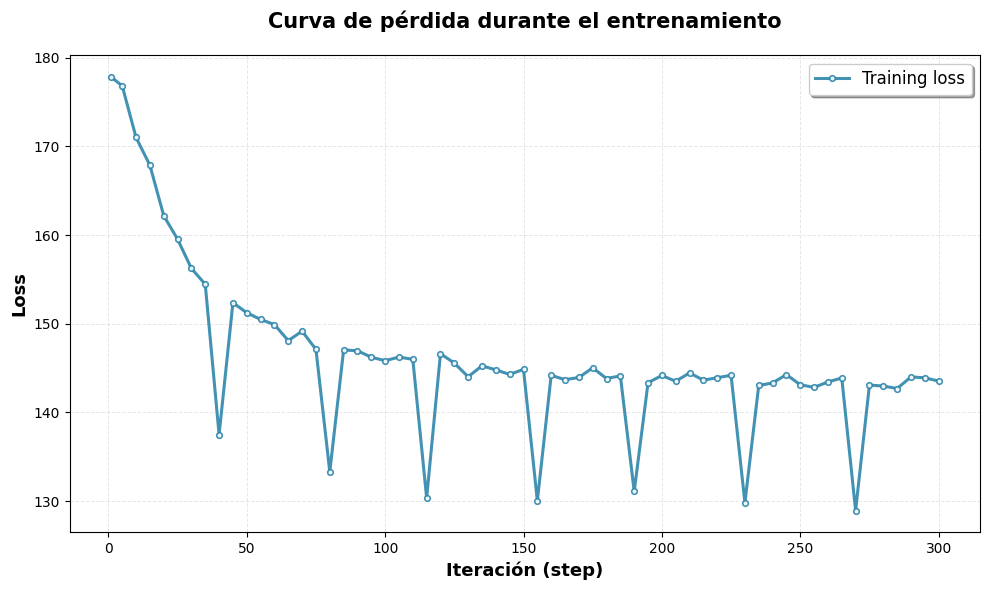

✅ Training points: 61


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# Training Loss
# -------------------------
train_mask = logs["loss"].notna() & logs["step"].notna()
steps_train = logs.loc[train_mask, "step"].values
loss_train = logs.loc[train_mask, "loss"].values

# -------------------------
# Eval Loss (si existe)
# -------------------------
if "eval_loss" in logs.columns:
    eval_mask = logs["eval_loss"].notna() & logs["step"].notna()
    steps_eval = logs.loc[eval_mask, "step"].values
    loss_eval = logs.loc[eval_mask, "eval_loss"].values
else:
    steps_eval, loss_eval = [], []
    print("⚠️ No hay columna eval_loss en logs")


plt.figure(figsize=(10, 6))

# === TRAINING ===
plt.plot(
    steps_train, loss_train,
    label="Training loss",
    linewidth=2.2,
    color='#2E86AB',
    alpha=0.9,
    marker='o',
    markersize=4,
    markerfacecolor='white',
    markeredgewidth=1.2,
    markeredgecolor='#2E86AB'
)

# === EVAL ===
if len(steps_eval) > 0:
    plt.plot(
        steps_eval, loss_eval,
        label="Eval loss",
        linewidth=2.2,
        color='#E74C3C',
        alpha=0.9,
        marker='s',
        markersize=4,
        markerfacecolor='white',
        markeredgewidth=1.2,
        markeredgecolor='#E74C3C'
    )

plt.xlabel("Iteración (step)", fontsize=13, fontweight='bold')
plt.ylabel("Loss", fontsize=13, fontweight='bold')
plt.title("Curva de pérdida durante el entrenamiento", fontsize=15, fontweight='bold', pad=20)
plt.legend(fontsize=12, frameon=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

print(f"✅ Training points: {len(steps_train)}")
if len(steps_eval) > 0:
    print(f"🔍 Eval points: {len(steps_eval)}")


In [ ]:
# 1. Guardar modelo y tokenizer
#trainer.save_model("llama3_lora_simplification_final")
# Guardar local
trainer.model.save_pretrained("llama3_2_3b_pls_lora/adapter")

# Definir versión
VERSION = "v6_T4_8_epochs_CE_PROMPTC1_TRL_HI_instruct_Hi_DIF_smooth"  # ← CAMBIAR ESTO CADA VEZ

# Copiar a Drive
!mkdir -p /content/drive/MyDrive/llama3_models
!cp -r llama3_2_3b_pls_lora/adapter /content/drive/MyDrive/llama3_models/adapter_{VERSION}

print(f"✅ Guardado: adapter_{VERSION}")
#tokenizer.save_pretrained("llama3_lora_simplification_final")
print("✅ Modelo guardado")

✅ Guardado: adapter_v6_T4_8_epochs_CE_PROMPTC1_TRL_HI_instruct_Hi_DIF_smooth
✅ Modelo guardado


In [ ]:
!mkdir -p "/content/drive/MyDrive/llama_models/Instruct_HI_CE_DIF_smooth_8"
!cp -r "/content/cochrane_data/llama3_1B_cosine_fixed" "/content/drive/MyDrive/llama_models/Instruct_HI_CE_DIF_smooth_8"

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel

# 4.Generación de Resumenes


In [ ]:
import torch
print("GPU disponible:", torch.cuda.is_available())
print("Dispositivo del modelo:", trainer.model.device)

GPU disponible: True
Dispositivo del modelo: cuda:0


In [ ]:
print(hf_ds["test"].column_names)
df_test = hf_ds["test"].to_pandas()
print(df_test.columns)

import re
import pandas as pd

def extract_source_from_prompt(prompt):
    """
    Extrae el texto entre 'original text' y 'simplified text' del prompt.
    Robusto ante espacios, mayúsculas y saltos de línea.
    """
    match = re.search(
        r"Input abstract:\s*[:\-–]?\s*(.*?)\s*Output PLS",
        prompt,
        re.IGNORECASE | re.DOTALL
    )
    if match:
        return match.group(1).strip()
    return ""

# Crear columna 'source' desde 'prompt'
df_test["source"] = df_test["prompt"].apply(extract_source_from_prompt)

# Mantener solo columnas necesarias
df_test = df_test[["source", "response"]]

# Mostrar ejemplo de verificación
print(df_test.head(2))

['prompt', 'response']
Index(['prompt', 'response'], dtype='object')
                                              source  \
0  Background\nPeriodic fever, aphthous stomatiti...   
1  Background\nMemory problems are a common cogni...   

                                            response  
0  Tonsillectomy for PFAPA syndrome (a rare cause...  
1  Cognitive rehabilitation for memory deficits a...  


## Generación de texto para el set TEST

In [ ]:
if "trainer" in locals() and hasattr(trainer, "model"):
    fine_tuned_model = trainer.model.eval()
else:
    fine_tuned_model = model.eval()

In [ ]:
import gc
import torch
from tqdm import tqdm
from difflib import SequenceMatcher
import re

def generate_simplifications_v2(
    df,
    model,
    tokenizer,
    instr_prompt,
    batch_size=2,
    max_source_tokens=512,
    sim_threshold=0.75,
    verbose=True,
):
    """
    Genera textos simplificados con regeneración multinivel.
    Si el texto generado está vacío, intenta regenerar automáticamente.
    """

    import gc, torch, re
    from tqdm import tqdm
    from difflib import SequenceMatcher

    tokenizer.padding_side = "right"
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.clean_up_tokenization_spaces = True

    model.eval()
    model.config.use_cache = True
    model.config.output_hidden_states = False
    model.config.return_dict = True

    torch.cuda.empty_cache()
    gc.collect()

    if verbose:
        print("\n🚀 Generación iniciada (modo seguro, con detección de vacíos)...")

    # === FUNCIONES AUXILIARES ===
    def truncate_text(text, max_tokens=max_source_tokens):
        tokens = text.split()
        if len(tokens) <= max_tokens:
            return text
        head = tokens[:max_tokens // 2]
        tail = tokens[-max_tokens // 2:]
        return " ".join(head + ["[...]"] + tail)

    def safe_generate(prompts, gen_params):
        inputs = tokenizer(
            prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=1536
        ).to(model.device)

        with torch.inference_mode():
            outputs = model.generate(**inputs, **gen_params)

        texts = tokenizer.batch_decode(
            outputs,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True,
            errors="replace"
        )
        return texts

    def extract_simplified_text(text):
        match = re.search(r"Output PLS\s*[:\-–]?\s*(.*)", text, re.IGNORECASE | re.DOTALL)
        if match:
            simplified = match.group(1).strip()
        else:
            simplified = text.strip()
        simplified = re.sub(r"<\|endoftext\|>", "", simplified)
        simplified = re.sub(r"\s+", " ", simplified).strip()
        return simplified

    # === PARÁMETROS DE GENERACIÓN ===
    GEN_PARAMS_L1 = {"max_new_tokens": 256, "temperature": 0.7, "top_p": 0.9, "do_sample": False,
                     "num_beams": 1, "repetition_penalty": 1.1,
                     "eos_token_id": tokenizer.eos_token_id, "pad_token_id": tokenizer.pad_token_id}

    GEN_PARAMS_L2 = {"max_new_tokens": 256, "temperature": 1.1, "top_p": 0.85, "do_sample": True,
                     "num_beams": 1, "repetition_penalty": 1.0,
                     "eos_token_id": tokenizer.eos_token_id, "pad_token_id": tokenizer.pad_token_id}

    GEN_PARAMS_L3 = {"max_new_tokens": 256, "temperature": 0.7, "top_p": 0.9, "do_sample": False,
                     "num_beams": 4, "repetition_penalty": 1.1,
                     "eos_token_id": tokenizer.eos_token_id, "pad_token_id": tokenizer.pad_token_id}

    # === PREPARACIÓN ===
    df = df.copy()
    df["source_for_generation"] = df["source"].apply(lambda x: truncate_text(x))
    if verbose:
        print("✅ Columna 'source_for_generation' creada correctamente")

    # === GENERACIÓN PRINCIPAL ===
    generated_texts, is_copy_list, was_regenerated_list = [], [], []
    regeneration_level_list, similarity_scores = [], []
    regeneration_count = 0

    for i in tqdm(range(0, len(df), batch_size), desc="Generando simplificaciones"):
        if i % 10 == 0:
            torch.cuda.empty_cache()
            gc.collect()

        batch_sources = df["source"].iloc[i:i+batch_size].tolist()
        batch_sources_trunc = df["source_for_generation"].iloc[i:i+batch_size].tolist()
        batch_prompts = [instr_prompt.format(source=s) for s in batch_sources_trunc]

        full_texts = safe_generate(batch_prompts, GEN_PARAMS_L1)

        for j, full_text in enumerate(full_texts):
            simplified = extract_simplified_text(full_text)
            source_idx = i + j
            if source_idx >= len(df):
                continue

            # 🔍 --- NUEVO BLOQUE: REGENERACIÓN SI EL TEXTO ESTÁ VACÍO ---
            if not simplified or len(simplified.strip()) == 0:
                if verbose:
                    print(f"⚠️ Texto vacío detectado en índice {source_idx}. Regenerando...")
                single_prompt = instr_prompt.format(source=batch_sources_trunc[j])
                regen_text = safe_generate([single_prompt], GEN_PARAMS_L2)[0]
                simplified = extract_simplified_text(regen_text)
                # Si sigue vacío, prueba con L3
                if not simplified or len(simplified.strip()) == 0:
                    beam_text = safe_generate([single_prompt], GEN_PARAMS_L3)[0]
                    simplified = extract_simplified_text(beam_text)

            # === Calcular similitud y regeneraciones ===
            sim = SequenceMatcher(None, batch_sources[j].lower(), simplified.lower()).ratio()
            is_copy = sim > sim_threshold
            regen_level = 0

            if is_copy:
                regeneration_count += 1
                single_prompt = instr_prompt.format(source=batch_sources_trunc[j])

                regen_text = safe_generate([single_prompt], GEN_PARAMS_L2)[0]
                simplified_regen = extract_simplified_text(regen_text)
                sim_regen = SequenceMatcher(None, batch_sources[j].lower(), simplified_regen.lower()).ratio()

                if sim_regen <= sim_threshold:
                    simplified, sim, is_copy, regen_level = simplified_regen, sim_regen, False, 2
                else:
                    beam_text = safe_generate([single_prompt], GEN_PARAMS_L3)[0]
                    simplified_beam = extract_simplified_text(beam_text)
                    sim_beam = SequenceMatcher(None, batch_sources[j].lower(), simplified_beam.lower()).ratio()

                    if sim_beam <= sim_threshold:
                        simplified, sim, is_copy, regen_level = simplified_beam, sim_beam, False, 3
                    else:
                        if sim_beam < sim_regen:
                            simplified, sim, regen_level = simplified_beam, sim_beam, 3
                        else:
                            simplified, sim, regen_level = simplified_regen, sim_regen, 2

            generated_texts.append(simplified)
            is_copy_list.append(is_copy)
            was_regenerated_list.append(regen_level > 0)
            regeneration_level_list.append(regen_level)
            similarity_scores.append(sim)

    # === GUARDAR RESULTADOS ===
    df["generated_text"] = generated_texts
    df["is_copy"] = is_copy_list
    df["was_regenerated"] = was_regenerated_list
    df["regeneration_level"] = regeneration_level_list
    df["similarity_score"] = similarity_scores

    if verbose:
        print(f"\n✅ Generación completada sin errores de memoria")
        print(f"📊 Total textos: {len(df)} | Regenerados: {sum(was_regenerated_list)} | Copias finales: {sum(is_copy_list)}")
        print(f"Promedio de similitud: {sum(similarity_scores)/len(similarity_scores):.3f}")

    return df


## Necesita source y response

In [ ]:
df_test50= df_test.sample(n=50, random_state=42)

print(df_test50.head())
print(len(df_test50))

                                                source  \
95   Background\nThis updated Cochrane Review of re...   
15   Background\nIn many countries emergency depart...   
30   Background\nPsychotherapy is regarded as the f...   
158  Background\nSpina bifida is a fetal neural tub...   
128  We included 12 trials in the original review (...   

                                              response  
95   Reminiscence therapy for dementia\nReview ques...  
15   Primary care professionals providing non‐urgen...  
30   Psychological therapies for borderline persona...  
158  Spina bifida repair and infant and maternal he...  
128  Transcutaneous Electrical Nerve Stimulation (T...  
50


In [ ]:
df_out = generate_simplifications_v2(
    df=df_test50,
    model=fine_tuned_model,
    tokenizer=tokenizer,
    instr_prompt=INSTR_PROMPT,
    batch_size=2,
)


🚀 Generación iniciada (modo seguro, con detección de vacíos)...
✅ Columna 'source_for_generation' creada correctamente


Generando simplificaciones: 100%|██████████| 25/25 [14:02<00:00, 33.71s/it]


✅ Generación completada sin errores de memoria
📊 Total textos: 50 | Regenerados: 0 | Copias finales: 0
Promedio de similitud: 0.024


In [ ]:
ref = "PLS_CE_KL_Instruct_Llama__2000_2epoch_low_DIF_smooth"
filename = f"pls_results_{ref}.csv"
save_path = f"/content/drive/MyDrive/{filename}"

df_out.to_csv(save_path, index=False, encoding="utf-8")
print(f"📁 Archivo guardado en: {save_path}")

📁 Archivo guardado en: /content/drive/MyDrive/pls_results_PLS_CE_KL_Instruct_Llama__2000_2epoch_low_DIF_smooth.csv


In [ ]:
# =====================================================================
# EJEMPLO DE SALIDA SIMPLIFICADA
# =====================================================================
print("\n🧾 Ejemplo de salida simplificada:\n" + "="*50)

# Seleccionamos un ejemplo aleatorio del DataFrame
import random
idx = random.randint(0, len(df_out) - 1)

print(f"\n🔹 Índice: {idx}")
print("\n--- Texto original (source) ---")
print(df_out.loc[idx, "source"][:1000])  # mostramos hasta 1000 caracteres por legibilidad

print("\n--- Texto simplificado generado ---")
print(df_out.loc[idx, "generated_text"])

print("\n" + "="*50)


🧾 Ejemplo de salida simplificada:

🔹 Índice: 15

--- Texto original (source) ---
Background
In many countries emergency departments (EDs) are facing an increase in demand for services, long waits, and severe crowding. One response to mitigate overcrowding has been to provide primary care services alongside or within hospital EDs for patients with non‐urgent problems. However, it is unknown how this impacts the quality of patient care and the utilisation of hospital resources, or if it is cost‐effective. This is the first update of the original Cochrane Review published in 2012. 
Objectives
To assess the effects of locating primary care professionals in hospital EDs to provide care for patients with non‐urgent health problems, compared with care provided by regularly scheduled emergency physicians (EPs). 
Search methods
We searched the Cochrane Central Register of Controlled Trials (the Cochrane Library; 2017, Issue 4), MEDLINE, Embase, CINAHL, PsycINFO, and King's Fund, from inception




# 5.Métricas


In [ ]:
# Extraer el texto después de "Input:"
#df_test["source"] = df_test["prompt"].str.split("### Original text:", n=1).str[-1].str.strip()

# Si tu prompt también tiene "Output:" al final, cortá ahí:
#df_test["source"] = df_test["source"].str.split("### Simplified text:", n=1).str[0].str.strip()

# Verificar
print(df_test["source"].head(1).values[0])

Background
Periodic fever, aphthous stomatitis, pharyngitis and cervical adenitis (PFAPA) syndrome is a rare clinical syndrome of unknown cause usually identified in children. Tonsillectomy is considered a potential treatment option for this syndrome. This is an update of a Cochrane Review first published in 2010 and previously updated in 2014. 
Objectives
To assess the effectiveness and safety of tonsillectomy (with or without adenoidectomy) compared with non‐surgical treatment in the management of children with PFAPA. 
Search methods
The Cochrane ENT Information Specialist searched the Cochrane ENT Trials Register; Central Register of Controlled Trials (CENTRAL 2019, Issue 4); PubMed; Ovid Embase; CINAHL; Web of Science; ClinicalTrials.gov; ICTRP and additional sources for published and unpublished trials. The date of the search was 15 October 2019. 
Selection criteria
Randomised controlled trials comparing tonsillectomy (with or without adenoidectomy) with non‐surgical treatment in 

## Todas las métricas

In [ ]:
# ============================================================================
# LIMPIAR DATAFRAME ANTES DE CALCULAR MÉTRICAS
# ============================================================================

print("🧹 LIMPIANDO DataFrame antes de calcular métricas...")
print("="*80)

# Ver estado actual
print(f"Columnas actuales: {len(df_out.columns)}")

# Identificar columnas de métricas a eliminar
metrics_to_remove = [col for col in df_test.columns if any(keyword in col for keyword in [
    'BERT_', 'AlignScore', 'TextStat_', 'FRE', 'FKGL', 'SMOG',
    'CLI', 'DCRS', 'GFI', 'similarity_score'
])]

print(f"Columnas de métricas a eliminar: {len(metrics_to_remove)}")
for col in metrics_to_remove:
    print(f"   - {col}")

# Eliminar columnas de métricas
df_test = df_test.drop(columns=metrics_to_remove, errors='ignore')

print(f"\n✅ DataFrame limpio: {len(df_test.columns)} columnas")
print("\n📋 Columnas restantes:")
for col in df_test.columns:
    print(f"   - {col}")

print("="*80)

# ============================================================================
# AHORA SÍ, CALCULAR MÉTRICAS DESDE CERO
# ============================================================================

print("\n🔄 Calculando métricas desde cero...")
print("="*80)

# Aquí va tu código de cálculo de métricas
# Por ejemplo:
# 1. BERTScore
# 2. AlignScore
# 3. TextStat
# etc.

print("\n✅ Listo para calcular métricas frescas sin duplicados")

🧹 LIMPIANDO DataFrame antes de calcular métricas...
Columnas actuales: 38
Columnas de métricas a eliminar: 0

✅ DataFrame limpio: 2 columnas

📋 Columnas restantes:
   - source
   - response

🔄 Calculando métricas desde cero...

✅ Listo para calcular métricas frescas sin duplicados


In [ ]:
!pip install evaluate -q

In [ ]:
print(df_out.columns)

Index(['source', 'response', 'source_for_generation', 'generated_text', 'is_copy', 'was_regenerated',
       'regeneration_level', 'similarity_score'],
      dtype='object')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
count_plain_title = df_out['generated_text'].str.startswith(
    ("Plain Title", "**Plain Title")
).sum()
count_plain_title
pct = 100 * count_plain_title / len(df_out)
print(f"{count_plain_title} textos ({pct:.2f}%) empiezan con 'Plain Title:'")

37 textos (74.00%) empiezan con 'Plain Title:'


In [ ]:
# ============================================================================
# 📊 PASO 1: CALCULAR MÉTRICAS (BERTScore + TextStat + AlignScore)
# ============================================================================

from bert_score import score as bertscore
import textstat
import pandas as pd
import torch
import transformers
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

EMB_MODEL = "sentence-transformers/all-mpnet-base-v2"  # cambia por modelo biomédico si quieres
DEVICE = "cuda" if (torch and torch.cuda.is_available()) else "cpu"
EMB_BATCH = 256   # reducir si OOM en T4 (prueba 128/64)

'''# Fix para AdamW
if not hasattr(transformers, "AdamW"):
    from torch.optim import AdamW
    transformers.AdamW = AdamW

from alignscore import AlignScore
'''

print("="*80)
print("📊 CALCULANDO MÉTRICAS")
print("="*80)

# --------------------------------------------------------
# 🔧 CONFIGURACIÓN INICIAL
# --------------------------------------------------------
col_ref = "response" #pls
col_gen = "generated_text"  # ← Cambié a generated_text (ajusta si es otro)
col_non_pls="source"

# Crear columna limpia si no existe
if col_gen not in df_out.columns and "generated_text" in df_out.columns:
    df_out["generated_clean"] = df_out["generated_text"].str.strip()
    col_gen = "generated_clean"

print(f"\n✓ Columna de referencia: {col_ref}")
print(f"✓ Columna generada: {col_gen}")
print(f"✓ Total textos: {len(df_out)}")

# --------------------------------------------------------
# 🧩 BERTScore
# --------------------------------------------------------
# --------------------------------------------------------
# 🧩 BERTScore 1 — modelo base (por defecto)
# --------------------------------------------------------
print("\n📊 Calculando BERTScore (modelo base)...")

refs = df_out[col_ref].astype(str).tolist()  # textos de referencia (PLS)
preds = df_out[col_gen].astype(str).tolist()  # textos generados
non_pls = df_out[col_non_pls].astype(str).tolist()  # abstract original

# Primer BERTScore: modelo por defecto ("roberta-large") o idioma "en"
P1, R1, F1_1 = bertscore(preds, refs, lang="en", verbose=False)

df_out["BERT_Precision"] = P1.numpy()
df_out["BERT_Recall"] = R1.numpy()
df_out["BERT_F1"] = F1_1.numpy()

print(f"✅ BERTScore (base) calculado")
print(f"   - Precision media: {P1.mean():.3f}")
print(f"   - Recall media: {R1.mean():.3f}")
print(f"   - F1 media: {F1_1.mean():.3f}")


# --------------------------------------------------------
# 🧩 BERTScore 2 — modelo alternativo o comparación distinta
# --------------------------------------------------------
print("\n📊 Calculando BERTScore (modelo alternativo: Longformer)...")

'''from evaluate import load
bertscore_alt = load("bertscore")

results_alt = bertscore_alt.compute(
    predictions=preds,
    references=refs,
    model_type="allenai/longformer-large-4096-finetuned-triviaqa",
    lang="en"
)


# Convertir los resultados en listas de precisión, recall y F1
P2 = results_alt["precision"]
R2 = results_alt["recall"]
F1_2 = results_alt["f1"]

# Guardar en df_out con nombres distintos
df_out["BERT2_Precision_Longformer"] = P2
df_out["BERT2_Recall_Longformer"] = R2
df_out["BERT2_F1_Longformer"] = F1_2

print(f"✅ BERTScore (Longformer) calculado")
print(f"   - Precision media: {sum(P2)/len(P2):.3f}")
print(f"   - Recall media: {sum(R2)/len(R2):.3f}")
print(f"   - F1 media: {sum(F1_2)/len(F1_2):.3f}")

'''


# --------------------------------------------------------
# 📚 TextStat (legibilidad y complejidad)
# --------------------------------------------------------
print("\n📚 Calculando métricas TextStat...")

def get_textstat_metrics(text):
    try:
        return {
            "flesch_reading_ease": textstat.flesch_reading_ease(text),
            "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
            "smog_index": textstat.smog_index(text),
            "coleman_liau_index": textstat.coleman_liau_index(text),
            "automated_readability_index": textstat.automated_readability_index(text),
            "dale_chall_readability_score": textstat.dale_chall_readability_score(text),
            "difficult_words": textstat.difficult_words(text),
            "linsear_write_formula": textstat.linsear_write_formula(text),
            "gunning_fog": textstat.gunning_fog(text),
        }
    except:
        return {key: None for key in [
            "flesch_reading_ease", "flesch_kincaid_grade", "smog_index",
            "coleman_liau_index", "automated_readability_index",
            "dale_chall_readability_score", "difficult_words",
            "linsear_write_formula", "gunning_fog"
        ]}

textstat_metrics = df_out[col_gen].apply(get_textstat_metrics)
df_textstat = pd.DataFrame(textstat_metrics.tolist()).add_prefix("TextStat_")

df_out = pd.concat([df_out, df_textstat], axis=1)

print(f"✅ TextStat calculado ({len(df_textstat.columns)} métricas)")

# --------------------------------------------------------
# 🔗 AlignScore o Equivalente Rapido
# --------------------------------------------------------
# -------- SI NO HAY SCORE, CALCULARLO (GPU / batching) --------
print("\n🔗 Calculando AlignScore (versión ligera)...")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"   Usando: {device}")

def compute_pairwise_align(ref_texts, gen_texts, model_name=EMB_MODEL, batch_size=EMB_BATCH, device=device):
    if SentenceTransformer is None:
        raise ImportError("sentence-transformers no está instalado. Instálalo con: pip install sentence-transformers")
    if len(ref_texts) != len(gen_texts):
        raise ValueError("refs y gens deben tener la misma longitud")

    model = SentenceTransformer(model_name, device=device)
    model.max_seq_length = 512

    def encode_list(texts):
        embs = []
        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding", leave=False):
            batch = texts[i:i+batch_size]
            b_emb = model.encode(batch, convert_to_tensor=True, show_progress_bar=False)
            b_emb = torch.nn.functional.normalize(b_emb, p=2, dim=1)
            embs.append(b_emb)
        return torch.cat(embs, dim=0)

    refs_emb = encode_list(ref_texts)
    gens_emb = encode_list(gen_texts)
    refs_emb = refs_emb.to(device)
    gens_emb = gens_emb.to(device)

    with torch.no_grad():
        cosines = torch.sum(refs_emb * gens_emb, dim=1).clamp(-1.0, 1.0).cpu().numpy()
    return cosines

# Calcular y guardar
align_scores = compute_pairwise_align(non_pls, preds)
df_out["AlignScore"] = align_scores

print(f"✅ AlignScore calculado (cosine embedding)")
print(f"   - Media: {sum(align_scores)/len(align_scores):.3f}")

print("\n" + "="*80)
print("✅ TODAS LAS MÉTRICAS CALCULADAS")
print("="*80)

# ============================================================================
# 📊 PASO 2: RESUMEN DE MÉTRICAS - TABLA PROFESIONAL
# ============================================================================

from tabulate import tabulate

print("\n🔧 Preparando tablas de resumen...")

# Renombrar TextStat con nombres cortos
textstat_rename = {
    "TextStat_flesch_reading_ease": "FRE",
    "TextStat_flesch_kincaid_grade": "FKGL",
    "TextStat_smog_index": "SMOG",
    "TextStat_coleman_liau_index": "CLI",
    "TextStat_dale_chall_readability_score": "DCRS",
    "TextStat_gunning_fog": "GFI",
}

# Aplicar renombrado
rename_dict = {k: v for k, v in textstat_rename.items() if k in df_out.columns}
df_out_display = df_out.rename(columns=rename_dict)

# Seleccionar columnas de métricas
metric_columns = [
    "BERT_Precision",
    "BERT_Recall",
    "BERT_F1",
    #"BERT2_F1_Longformer",
    "AlignScore"
] + [v for v in textstat_rename.values() if v in df_out_display.columns]

# Añadir columnas TextStat no renombradas
other_textstat = [col for col in df_out.columns if col.startswith("TextStat_") and col not in textstat_rename]
metric_columns.extend(other_textstat)

# Crear DataFrame de métricas sin duplicados
df_metrics = df_out_display[metric_columns].copy()
df_metrics = df_metrics.loc[:, ~df_metrics.columns.duplicated()]

print(f"✓ Métricas seleccionadas: {len(df_metrics.columns)} columnas")

# ============================================================================
# ✅ CREAR stats_df
# ============================================================================

stats_df = pd.DataFrame({
    'Mean': df_metrics.mean(numeric_only=True),
    'Std': df_metrics.std(numeric_only=True),
    'Min': df_metrics.min(numeric_only=True),
    'Max': df_metrics.max(numeric_only=True),
    'Median': df_metrics.median(numeric_only=True),
}).T

print(f"✓ stats_df creado: {stats_df.shape}")

# ============================================================================
# 📈 TABLA DE MÉTRICAS POR TEXTO (primeros 10)
# ============================================================================

print("\n" + "="*120)
print("📊 MÉTRICAS POR TEXTO (Primeros 10 ejemplos)")
print("="*120)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.3f}'.format)

print("\n")
print(df_metrics.head(10).to_string())
print("\n" + "="*120)

# ============================================================================
# 📊 ESTADÍSTICAS GLOBALES
# ============================================================================

print("\n" + "="*120)
print("📈 ESTADÍSTICAS GLOBALES")
print("="*120 + "\n")

# Preparar datos para tabulate
table_data = []
for stat_name in ['Mean', 'Std', 'Min', 'Max', 'Median']:
    row = [stat_name] + [f"{val:.3f}" for val in stats_df.loc[stat_name]]
    table_data.append(row)

headers = ['Statistic'] + list(stats_df.columns)

print(tabulate(table_data, headers=headers, tablefmt='grid',
               stralign='center', numalign='center'))
print()

# ============================================================================
# 📊 REFERENCIA COMPARATIVA (Modelos del paper CL4Health 2025)
# ============================================================================

reference_data = [
    ["DeepSeek-R1-7B",        16.99, 22.75, 17.69, 12.31, 14.80, 9.45, 0.7955, 0.8496],
    ["Gemini-1.3-Flash",      9.60,  66.87, 8.75,  9.08,  6.90,  5.94, 0.6333, 0.8474],
    ["GPT-4-32K",            12.48,  48.52, 13.39, 11.20, 10.80, 7.41, 0.7801, 0.8519],
    ["GPT-4o",               11.49,  57.13, 11.16,  9.91,  9.09, 6.88, 0.7383, 0.8527],
    ["GPT-3.5-Turbo-16K",    15.52,  28.08, 17.33, 12.59, 13.91, 8.60, 0.8781, 0.8585],
    ["Llama-3.2-3B",         16.42,  21.96, 18.58, 10.79, 15.73, 9.39, 0.8785, 0.8490],
]

ref_headers = ["Model", "CLI ↓", "FRE ↑", "GFI ↓", "SMOG ↓", "FKGL ↓", "DCRS ↓", "AlignScore ↑", "BERTScore ↑"]

print("\n" + "="*120)
print("📊 TABLA DE REFERENCIA (Valores del paper CL4Health-2025)")
print("="*120 + "\n")

print(tabulate(reference_data, headers=ref_headers, tablefmt="grid",
               stralign="center", numalign="center"))
print()

# ============================================================================
# 🎯 RESUMEN EJECUTIVO
# ============================================================================

print("\n" + "="*100)
print("🎯 RESUMEN EJECUTIVO")
print("="*100)

key_metrics = {
    "Semantic Similarity": {
        "BERT F1": df_metrics["BERT_F1"].mean() if "BERT_F1" in df_metrics.columns else None,
        "AlignScore": df_metrics["AlignScore"].mean() if "AlignScore" in df_metrics.columns else None,
    },
    "Readability": {
        "Flesch Ease (FRE)": df_metrics["FRE"].mean() if "FRE" in df_metrics.columns else None,
        "FK Grade Level": df_metrics["FKGL"].mean() if "FKGL" in df_metrics.columns else None,
        "SMOG Index": df_metrics["SMOG"].mean() if "SMOG" in df_metrics.columns else None,
    },
    "Complexity": {
        "Coleman-Liau": df_metrics["CLI"].mean() if "CLI" in df_metrics.columns else None,
        "Dale-Chall": df_metrics["DCRS"].mean() if "DCRS" in df_metrics.columns else None,
        "Gunning Fog": df_metrics["GFI"].mean() if "GFI" in df_metrics.columns else None,
    }
}

for category, metrics in key_metrics.items():
    print(f"\n📌 {category}:")
    for metric_name, value in metrics.items():
        if value is not None:
            # Emoji según valor
            if "F1" in metric_name or "AlignScore" in metric_name:
                emoji = "✅" if value >= 0.7 else "⚠️" if value >= 0.5 else "❌"
            elif "Flesch" in metric_name or "FRE" in metric_name:
                emoji = "✅" if value >= 60 else "⚠️" if value >= 50 else "❌"
            elif any(x in metric_name for x in ["Grade", "SMOG", "Coleman", "Dale", "Gunning"]):
                emoji = "✅" if value <= 10 else "⚠️" if value <= 12 else "❌"
            else:
                emoji = "📊"

            print(f"   {emoji} {metric_name:.<35} {value:>8.3f}")

print("="*100)

# =====================================================================
# 🎯 RESUMEN EJECUTIVO (con comparación a Llama-3.2-3B)
# =====================================================================

print("\n" + "="*100)
print("🎯 RESUMEN EJECUTIVO (comparado con Llama-3.2-3B)")
print("="*100)

# === 1️⃣ Valores de referencia (Llama-3.2-3B) ===
llama3_ref = {
    "CLI": 16.42,
    "FRE": 21.96,
    "GFI": 18.58,
    "SMOG": 10.79,
    "FKGL": 15.73,
    "DCRS": 9.39,
    "AlignScore": 0.8785,
    "BERT_F1": 0.849
}

# === 2️⃣ Tu resumen de métricas ===
key_metrics = {
    "Semantic Similarity": {
        "BERT_F1": df_metrics["BERT_F1"].mean() if "BERT_F1" in df_metrics.columns else None,
        "AlignScore": df_metrics["AlignScore"].mean() if "AlignScore" in df_metrics.columns else None,
    },
    "Readability": {
        "FRE": df_metrics["FRE"].mean() if "FRE" in df_metrics.columns else None,
        "FKGL": df_metrics["FKGL"].mean() if "FKGL" in df_metrics.columns else None,
        "SMOG": df_metrics["SMOG"].mean() if "SMOG" in df_metrics.columns else None,
    },
    "Complexity": {
        "CLI": df_metrics["CLI"].mean() if "CLI" in df_metrics.columns else None,
        "DCRS": df_metrics["DCRS"].mean() if "DCRS" in df_metrics.columns else None,
        "GFI": df_metrics["GFI"].mean() if "GFI" in df_metrics.columns else None,
    }
}

# === 3️⃣ Mostrar métricas comparadas ===
for category, metrics in key_metrics.items():
    print(f"\n📌 {category}:")
    for metric_name, value in metrics.items():
        if value is not None:
            # Valor de referencia (si existe)
            ref_val = llama3_ref.get(metric_name, None)

            # Emoji según desempeño relativo
            if "F1" in metric_name or "AlignScore" in metric_name:
                emoji = "✅" if value >= 0.7 else "⚠️" if value >= 0.5 else "❌"
            elif "FRE" in metric_name:
                emoji = "✅" if value >= 60 else "⚠️" if value >= 50 else "❌"
            elif any(x in metric_name for x in ["Grade", "SMOG", "CLI", "DCRS", "GFI", "FKGL"]):
                emoji = "✅" if value <= 10 else "⚠️" if value <= 12 else "❌"
            else:
                emoji = "📊"

            # Mostrar línea con comparación
            if ref_val is not None:
                diff = value - ref_val
                arrow = "⬆️" if diff > 0 else "⬇️" if diff < 0 else "➡️"
                print(f"   {emoji} {metric_name:<20} {value:>8.3f}  ({arrow} vs Llama3 {ref_val:>8.3f})")
            else:
                print(f"   {emoji} {metric_name:<20} {value:>8.3f}")

print("="*100)
# ============================================================================
# 💾 EXPORTAR A CSV
# ============================================================================

df_metrics.to_csv("metrics_complete.csv", index=False)
stats_df.T.to_csv("metrics_summary.csv")

print("\n💾 Tablas guardadas:")
print("   - metrics_complete.csv (todas las métricas por texto)")
print("   - metrics_summary.csv (estadísticas resumidas)")
print()

📊 CALCULANDO MÉTRICAS

✓ Columna de referencia: response
✓ Columna generada: generated_text
✓ Total textos: 50

📊 Calculando BERTScore (modelo base)...
✅ BERTScore (base) calculado
   - Precision media: 0.861
   - Recall media: 0.835
   - F1 media: 0.847

📊 Calculando BERTScore (modelo alternativo: Longformer)...

📚 Calculando métricas TextStat...
✅ TextStat calculado (9 métricas)

🔗 Calculando AlignScore (versión ligera)...
   Usando: cuda


✅ AlignScore calculado (cosine embedding)
   - Media: 0.892

✅ TODAS LAS MÉTRICAS CALCULADAS

🔧 Preparando tablas de resumen...
✓ Métricas seleccionadas: 13 columnas
✓ stats_df creado: (5, 13)

📊 MÉTRICAS POR TEXTO (Primeros 10 ejemplos)


   BERT_Precision  BERT_Recall  BERT_F1  AlignScore    FRE   FKGL   SMOG    CLI   DCRS    GFI  TextStat_automated_readability_index  TextStat_difficult_words  TextStat_linsear_write_formula
0           0.880        0.839    0.859       0.929 17.147 15.362 16.909 16.781 12.151 19.900                                16.207                        66                          13.833
1           0.875        0.837    0.856       0.842 42.455 12.604 13.968 14.293 11.391 14.140                                15.719                        52                          11.500
2           0.844        0.829    0.836       0.915 -1.291 17.961 18.244 20.847 14.343 22.445                                20.045                        87                          15.000


In [ ]:
import textwrap
import random

# =====================================================================
# EJEMPLO DE SALIDA SIMPLIFICADA
# =====================================================================
print("\n🧾 Ejemplo de salida simplificada:\n" + "="*50)

# Seleccionamos un ejemplo aleatorio del DataFrame
idx = random.randint(0, len(df_out) - 1)

print(f"\n🔹 Índice: {idx}")

# Función auxiliar para mostrar texto con ancho fijo y saltos de línea
def mostrar_texto_formateado(texto, ancho=150):
    # Reemplaza saltos de línea escapados por saltos reales, si los hay
    texto = texto.replace("\\n", "\n")
    # Divide el texto en líneas y aplica textwrap a cada una
    lineas = []
    for linea in texto.splitlines():
        # Ajusta cada línea a máximo 'ancho' caracteres
        lineas.extend(textwrap.wrap(linea, width=ancho, replace_whitespace=False) or [""])
    print("\n".join(lineas))

# Texto original (hasta 1000 caracteres)
print("\n--- Texto original (source) ---")
mostrar_texto_formateado(df_out.loc[idx, "source"][:1000], ancho=150)

# Texto simplificado generado
print("\n--- Texto simplificado generado ---")
mostrar_texto_formateado(df_out.loc[idx, "generated_text"], ancho=150)

print("\n" + "="*50)



🧾 Ejemplo de salida simplificada:

🔹 Índice: 70

--- Texto original (source) ---
Background
Closure of asylums and institutions for the mentally ill, coupled with government policies focusing on reducing the number of hospital beds for people
with severe mental illness in favour of providing care in a variety of non‐hospital settings, underpins the rationale behind care in the community. A
major thrust towards community care has been the development of community mental health teams (CMHT).
Objectives
To evaluate the effects of community mental health team (CMHT) treatment for anyone with serious mental illness compared with standard non‐team
management.
Search methods
We searched The Cochrane Schizophrenia Group Trials Register (March 2006). We manually searched the Journal of Personality Disorders, and contacted
colleagues at ENMESH, ISSPD and in forensic psychiatry.
Selection criteria
We included all randomised controlled trials of CMHT management versus non‐team standard care.
Data

In [ ]:

import textwrap

# Filtrar los casos con AlignScore < 0.3
low_align = df_out[df_out["AlignScore"] < 0.3]

# Mostrar cuántos hay
print(f"🧮 {len(low_align)} ejemplos con AlignScore < 0.3\n")

# Iterar sobre los primeros 10 ejemplos
for i, row in enumerate(low_align[["source", "response", "generated_text", "AlignScore"]].head(10).itertuples(), start=1):
    print(f"\n🔹 Ejemplo {i} | AlignScore: {row.AlignScore:.3f}")
    print("=" * 150)

    # Texto original (source)
    print("\n--- Texto original (source) ---")
    print(textwrap.fill(row.source.replace("\\n", "\n"), width=150, replace_whitespace=False))

    # Respuesta de referencia (ground truth)
    print("\n--- Resumen de referencia (response) ---")
    print(textwrap.fill(row.response.replace("\\n", "\n"), width=150, replace_whitespace=False))

    # Texto generado por el modelo
    print("\n--- Texto simplificado generado ---")
    print(textwrap.fill(row.generated_text.replace("\\n", "\n"), width=150, replace_whitespace=False))

    print("-" * 150)


🧮 0 ejemplos con AlignScore < 0.3



In [ ]:
# Filtrar los casos con AlignScore > 0.8
low_align = df_out[df_out["AlignScore"] > 0.8]

# Mostrar cuántos hay
print(f"🧮 {len(low_align)} ejemplos con AlignScore > 0.8\n")

# Iterar sobre los primeros 10 ejemplos
for i, row in enumerate(low_align[["source", "response", "generated_text", "AlignScore"]].head(10).itertuples(), start=1):
    print(f"\n🔹 Ejemplo {i} | AlignScore: {row.AlignScore:.3f}")
    print("=" * 150)

    # Texto original (source)
    print("\n--- Texto original (source) ---")
    print(textwrap.fill(row.source.replace("\\n", "\n"), width=150, replace_whitespace=False))

    # Respuesta de referencia (ground truth)
    print("\n--- Resumen de referencia (response) ---")
    print(textwrap.fill(row.response.replace("\\n", "\n"), width=150, replace_whitespace=False))

    # Texto generado por el modelo
    print("\n--- Texto simplificado generado ---")
    print(textwrap.fill(row.generated_text.replace("\\n", "\n"), width=150, replace_whitespace=False))

    print("-" * 150)


🧮 46 ejemplos con AlignScore > 0.8


🔹 Ejemplo 1 | AlignScore: 0.929

--- Texto original (source) ---
Background
This updated Cochrane Review of reminiscence therapy (RT) for dementia was first published in 1998, and last updated in 2005. RT involves
the discussion of memories and past experiences with other people using tangible prompts such as photographs or music to evoke memories and stimulate
conversation. RT is implemented widely in a range of settings using a variety of formats. 
Objectives
To assess the effects of RT on people living
with dementia and their carers, taking into account differences in its implementation, including setting (care home, community) and modality (group,
individual). 
Search methods
We searched ALOIS (the Cochrane Dementia and Cognitive Improvement Group's Specialized Register) on 6 April 2017 using
the search term 'reminiscence.' 
Selection criteria
We included all randomised controlled trials of RT for dementia in which the duration of the
interventi

In [ ]:
import textwrap

for i, text in enumerate(df_out["generated_text"].head(10), start=1):
    print(f"\n🔹 Ejemplo {i}:")
    print(textwrap.fill(text, width=150))  # wrap de 150 caracteres por línea
    print("-" * 150)


🔹 Ejemplo 1:
Plain Title Tonsillectomy for periodic fever, aphthous stomatitis, pharyngitis and cervical adenitis (PFAPA) syndrome in children Rationale Periodic
fever, aphthous stomatitis, pharyngitis and cervical adenitis (PFAPA) syndrome is a rare condition that causes recurring episodes of fever, mouth
ulcers, sore throat and swollen lymph nodes in children. The exact cause of PFAPA is unknown, but it is thought to be related to abnormal immune
system function. Treatment options are limited, and there is currently no cure for the condition. Tonsillectomy, or removal of the tonsils, is
sometimes considered a potential treatment option for PFAPA. This review aims to evaluate the effectiveness and safety of tonsillectomy compared to
other treatments for children with PFAPA. Trial Design This review included two small randomised controlled trials that compared tonsillectomy (with
or without adenoidectomy) with non-surgical treatment in children with PFAPA. The trials involved a total 